In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# data cleaning
def dataClean(df):
  # there's an extra column at the end of the data set that needs removing.
  df = df.drop(columns=["id", "Unnamed: 32"])
  # other than this, there is no more data cleaning to do.
  return df

In [3]:
# First we isolate the classification column of the datasset ('diagnosis').
# Because 'diagnosis' uses M & B as labels and CFS uses numbers, we map
# M and B to 1 and 0, respectively.
def predClassMapping(df):
  df['diagnosis'] = pd.Series(df.diagnosis).map({'M':1,'B':0});
  return df

In [4]:
#12/24
# CORRELATION FEATURE SELECTION
R_XY = None
# tauRed = 0.8, k = 6
def corrFeatureSelection(df, k = 10, tauRedundancy = 0.8):
  # 1) Sort features by absolute correlation with the label (descending)
  targetCorr = df.corr()['diagnosis'].abs().sort_values(ascending=False)
  R_XY = targetCorr
  # 2) Now pick features one by one from the most strongly correlated
  #    to the least, but skip any feature that is "too correlated"

  selectedFeatures = []
  rejectedFeatures = []

  for feature in targetCorr.index:
    if feature == 'diagnosis':
      continue  # Skip the label itself

    # Check correlation with already selected features
    aboveThreshold = False
    for alreadySelected in selectedFeatures:
      # If the correlation is above the threshold, skip
      if abs(df[feature].corr(df[alreadySelected])) > tauRedundancy:
        aboveThreshold = True
        rejectedFeatures.append(feature)
        break

    if not aboveThreshold:
      selectedFeatures.append(feature)

    # If we already have our 10 features, stop
    if len(selectedFeatures) == k:
      break

  print("Selected features:", selectedFeatures)
  print("Num features:", len(selectedFeatures))
  # This will give up to 10 features that are:
  # - highly correlated with the label (because we started with that sorted list),
  # - but have low correlation with each other (due to our threshold check).

  selectedDF = df[['diagnosis'] + selectedFeatures]

  return { "sfCorrMatrix": selectedDF.corr(), "selectedDF": selectedDF,"selectedFeatures": selectedFeatures, "rejectedFeatures": rejectedFeatures }

Selected features: ['concave points_worst', 'radius_worst', 'radius_se', 'texture_worst', 'smoothness_worst', 'symmetry_worst']
Num features: 6


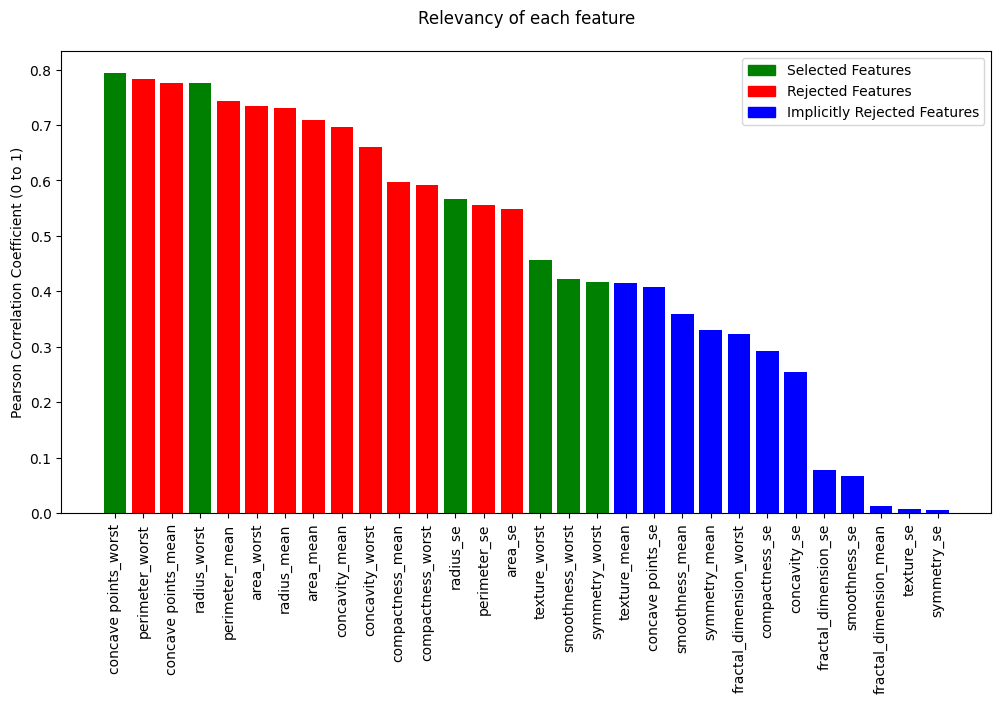

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load and process data
df = pd.read_csv("data.csv")
df = dataClean(df)
df = predClassMapping(df)

# Compute correlations and perform CFS
R_XY = df.corr()['diagnosis'].abs().sort_values(ascending=False)
# Remove the 'diagnosis' entry from the correlation Series
R_XY = R_XY.drop('diagnosis')

res = corrFeatureSelection(df, k=6, tauRedundancy=0.8)

# Extract features and their correlation values (without 'diagnosis')
features = R_XY.index
correlations = R_XY.values

# Create a color list for each feature based on its status:
colors = []
for feature in features:
    if feature in res["selectedFeatures"]:
        colors.append("green")
    elif feature in res["rejectedFeatures"]:
        colors.append("red")
    else:
        # Implicitly rejected (not processed) features
        colors.append("blue")

# Plot the bar chart with the custom colors
plt.figure(figsize=(12, 6))
plt.bar(features, correlations, color=colors)
plt.title('Relevancy of each feature', pad=20)
plt.ylabel('Pearson Correlation Coefficient (0 to 1)')
plt.xticks(rotation=90)

# Create a custom legend to clarify the colors
selected_patch = mpatches.Patch(color="green", label="Selected Features")
rejected_patch = mpatches.Patch(color="red", label="Rejected Features")
implicit_patch = mpatches.Patch(color="blue", label="Implicitly Rejected Features")
plt.legend(handles=[selected_patch, rejected_patch, implicit_patch])

plt.show()

In [6]:
# 10/24
# SPLIT DATA SET
import sklearn as skl
from sklearn.model_selection import train_test_split


def splitData(df, testSize = 0.20):
  # Split the label column from the features
  Y = df.loc[:, 'diagnosis']
  X = df.loc[:, df.columns != 'diagnosis']

  # Now split the X and Y datasets into train/test (0.8/0.2 split by default)
  Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=testSize, random_state=23)
  return [Xtrain, Xtest, Ytrain, Ytest]

In [7]:
# 01/02/2025
# This is the data preprocessing handler. Can be used to execute any one or multiple forms of data preprocessing (cleaning, mapping, feature selection, data splitting).
# NOTE: If data set splitting and CFS are to be done in the same call, the CFS option MUST be first in the `processes` array (so that the dataset is feature selected, and THEN split)
def dataPreProcessing(dsFile = "data", df = None, processes = ["clean", "predMap", "CFS", "splitSet"], kFeatures = 10, tauRedundancy = 0.8, testSize = 0.20):
  returnVars = {"df": None, "CFS Corr Matrix": None, "Xtrain": None, "Xtest": None, "Ytrain": None, "Ytest": None}
  if df is None:
    df = pd.read_csv(dsFile + '.csv')

  for process in processes:
    match process:
      case "clean":
        df = dataClean(df)
      case "predMap":
        df = predClassMapping(df)
      case "CFS":
        res = corrFeatureSelection(df, kFeatures, tauRedundancy)
        returnVars["CFS Corr Matrix"] = res["sfCorrMatrix"]
        df = res["selectedDF"]
      case "splitSet":
        Xtrain, Xtest, Ytrain, Ytest = splitData(df, testSize)
        returnVars["Xtrain"] = Xtrain
        returnVars["Xtest"] = Xtest
        returnVars["Ytrain"] = Ytrain
        returnVars["Ytest"] = Ytest
      case _:
        raise Exception("Processes param is empty. Options: ['clean', 'predMap', 'CFS', 'splitSet']")

  returnVars["df"] = df
  return returnVars